In [1]:
import numpy as np
from scipy.special import erf
import os
import sys
import time
import copy
import logging
import matplotlib.pyplot as plt

# Navigate to the parent directory of the project structure
project_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_dir, 'src')
log_dir = os.path.join(project_dir, 'log')
fig_dir = os.path.join(project_dir, 'fig')

os.makedirs(log_dir, exist_ok=True)
os.makedirs(fig_dir, exist_ok=True)

# Add the src directory to sys.path
sys.path.append(src_dir)

from estimator.Gaussian import GaussianEstimator
from analysis.commons import batch_estimator_estimated_delta, compute_bootstrap_range
from utils.constants import WORKERS

In [11]:
def generate_default_configuration():
    epsilon = 1
    claimed_epsilon = 1
    gamma = 0.01

    dataset_settings = {
        'database_0': [0],
        'database_1': [1],
        'sensitivity': 1.,
        'epsilon': epsilon,
        'claimed_epsilon': claimed_epsilon,
        'delta': 0.00001
    }

    kwargs = {
        'dataset_settings': dataset_settings, 
        'gamma': gamma,
        'training_set_size': 2*10**5, 'validation_set_size': 10**6
    }
    return kwargs

def store_array_str(data_array):
    converted_str = np.array_str(data_array)
    converted_str = converted_str.replace(' ',',')
    return converted_str

In [12]:
logfile_path = os.path.join(log_dir, 'NN-EllipticalGaussian.log')

logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s %(message)s",
        handlers=[
            logging.FileHandler(logfile_path),
            logging.StreamHandler()
        ]
    )

logging.info('Initialize the experimental settings')
kwargs = generate_default_configuration()

In [13]:
claimed_epsilon_list = np.array([0.01])
d = 10
kwargs['dataset_settings']['database_0'] = [0]*d
kwargs['dataset_settings']['database_1'] = [np.sqrt(1.0/d)]*d

estimated_delta_list = []

for claimed_epsilon in claimed_epsilon_list:
    kwargs['dataset_settings']['claimed_epsilon'] = claimed_epsilon
    estimator = GaussianEstimator(kwargs)
    classifier_args = {"n_epoch": 50, "batch_size": 500, "lr": 0.0001, "n_batches": 100, "model": None, "use_gpu": True}
    estimator.build(classifier="NeuralNetwork", classifier_args=classifier_args)
    logging.info(estimator.output_)
    estimated_delta_list.append(estimator.output_['estimated_delta'])

Initializing model


2025-07-03 16:07:44,469 [epoch 1, batch   100] average loss: 1.165608 learning rate=0.000100000
2025-07-03 16:07:44,982 [epoch 1, batch   200] average loss: 1.183785 learning rate=0.000100000
2025-07-03 16:07:45,496 [epoch 1, batch   300] average loss: 1.118878 learning rate=0.000100000
2025-07-03 16:07:46,009 [epoch 1, batch   400] average loss: 1.081105 learning rate=0.000100000
2025-07-03 16:07:46,546 [epoch 2, batch   100] average loss: 1.047059 learning rate=0.000100000
2025-07-03 16:07:47,065 [epoch 2, batch   200] average loss: 1.189065 learning rate=0.000100000
2025-07-03 16:07:47,581 [epoch 2, batch   300] average loss: 1.112640 learning rate=0.000100000
2025-07-03 16:07:48,095 [epoch 2, batch   400] average loss: 1.130669 learning rate=0.000100000
2025-07-03 16:07:48,631 [epoch 3, batch   100] average loss: 1.087670 learning rate=0.000100000
2025-07-03 16:07:49,317 [epoch 3, batch   200] average loss: 1.139399 learning rate=0.000100000
2025-07-03 16:07:49,833 [epoch 3, batch 

Training completed


2025-07-03 16:09:31,394 Compute the empirical error rate requires 1.0955 seconds


In [14]:
from scipy import special
sensitivity = 1
epsilon1 = 1
delta1 = 0.00001
gaussian_scale = 2*np.log(1.25/delta1)*np.power(sensitivity, 2)/np.power(epsilon1, 2)
x_star = 0.5*(1-2*gaussian_scale*claimed_epsilon_list)
test = 0.5*(1 + special.erf(x_star/(np.sqrt(2*gaussian_scale))) - np.exp(claimed_epsilon_list)*(1 + special.erf((x_star-1)/(np.sqrt(2*gaussian_scale)))))

print(test)
print(estimated_delta_list)

[0.07768296]
[0.06708938427638422]


In [8]:
from scipy import special
sensitivity = 1
epsilon1 = 1
delta1 = 0.00001
gaussian_scale = 2*np.log(1.25/delta1)*np.power(sensitivity, 2)/np.power(epsilon1, 2)
x_star = 0.5*(1-2*gaussian_scale*claimed_epsilon_list)
test = 0.5*(1 + special.erf(x_star/(np.sqrt(2*gaussian_scale))) - np.exp(claimed_epsilon_list)*(1 + special.erf((x_star-1)/(np.sqrt(2*gaussian_scale)))))

print(test)
print(estimated_delta_list)

[0.07768296]
[0.06807923344012667]


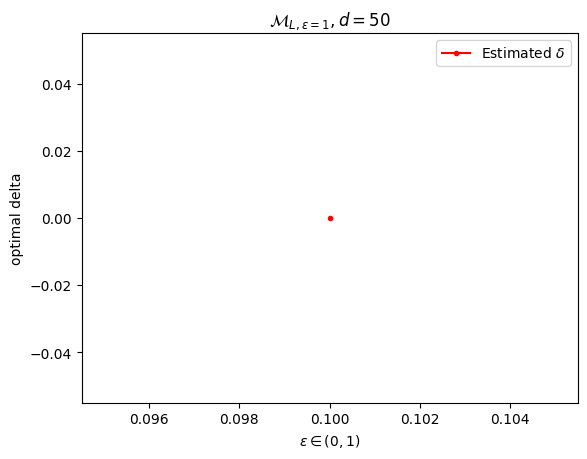

In [5]:
figfile_path = os.path.join(fig_dir, 'Laplace_kd.png')

plt.title(r'$\mathcal{M}_{L, \epsilon=1}, d=50$')
plt.xlabel(r"$\epsilon \in (0, 1)$")
plt.ylabel("optimal delta")

plt.plot(claimed_epsilon_list, estimated_delta_list , linestyle='-', marker='.', color ="red", label=r"Estimated $\delta$")
plt.legend(loc='upper right')
plt.savefig(figfile_path, bbox_inches = 'tight', dpi = 150);
plt.show()

In [1]:
import torch

if torch.cuda.is_available():
    print("GPU is available!")
    print("Number of GPUs:", torch.cuda.device_count())
    print("Current GPU:", torch.cuda.current_device())
    print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("GPU is NOT available.")

GPU is available!
Number of GPUs: 1
Current GPU: 0
GPU Name: Tesla T4


In [2]:
torch.cuda.is_available()

True